# **Text Mining Project - Group 8** 

|      |     Student Name     |     Student ID     |
|---   |         ---          |           ---          |
| 1    |      Mariana Cabral    |       20230532       |
| 2    |      Sofia Pereira       |       20230568	       |
|3| Susana Pires |202305???? |


### Goal: 
**Implement an NLP Classification model able to predict, for each property, if it was unlisted (1) in the next quarter or is still listed (0)**


Docs for orgaization: https://docs.google.com/document/d/1cU9rkjof2L1qmxQwBYIpzOMezUiTN0xATmCpiLne1_c/edit?usp=sharing

Link for report: https://liveeduisegiunl-my.sharepoint.com/:w:/g/personal/20230568_novaims_unl_pt/Ee5Xaa2zAJtOj_6C7T8apkgB3_gYWxfbe4SQxlCq9Ld0PA?e=YFEFAF

## **TO DO:**
- Decide if we think host_about is important (since it repeats so many times as each host can have more than 1 property);
- Check how many properties have comments;
- Check small text (does it have any meaning?);
- Treat Emojis;
- If we have languages we can calculate stopwords and all for all of them;
- Test different models for each feature engineering method (and with and without undersampling/oversapling).

We can do hold-out method.\
Sets in comments.

### **1. Import Libraries &  Documents:**

#### Libraries:

In [232]:
#!pip install bs4
#!pip install nltk
#!pip install langdetect

In [233]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud 

# Preprocessing and Feature Extraction
from bs4 import BeautifulSoup #remove html tags
from langdetect import detect, LangDetectException
# NLTK
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
from tqdm import tqdm


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Import Datasets:

In [234]:
train = pd.read_excel('Project Corpora/train.xlsx')
train_reviews = pd.read_excel('Project Corpora/train_reviews.xlsx')
test= pd.read_excel('Project Corpora/test.xlsx')
test_reviews = pd.read_excel('Project Corpora/test_reviews.xlsx')

In [235]:
train.head()

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [236]:
train_reviews.head()

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [237]:
test.head()

,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
3,4,Charming Apartment Close to the Bay of Cascais...,:)
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


In [238]:
test_reviews.head()

,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...
3,1,We've been in Lisbon in march 2013 (3 adults a...
4,1,Our host Antonio was very helpful with informa...


#### Documents (Copies of the Datasets):

The **Corpora** is composed by the following documents:

•  _`airbnb_df_train `_(train) (6,248 lines): Contains the Airbnb and host descriptions
(“description” and “host_about” columns), as well as the information regarding the
property listing status (“unlisted” column). A property is considered unlisted (1) if
it got removed from the quarterly Airbnb list and it is considered listed (0) if it
remains on that same list.

• _`airbnb_df_train_reviews`_ (train_reviews) (361,281 lines): This file has all the guests’
comments made to each Airbnb property. Note that there can be more than one
comment per property, not all properties have comments, and comments can
appear in many languages.

• _`airbnb_df_test`_ (test) (695 lines): The structure of this dataset is the same as the train set, except that it does not contain the “unlisted” column.

• _`airbnb_df_test_reviews `_ (test_reviews) (41,866 lines): same srtucter as the train reviews set, but the comments correspond to the properties
present on the test set.

**Important notes** about the relation between  _`airbnb_df_train `_ &  _`airbnb_df_train_reviews`_:
- There can be more than one comment per listing;
- Not all properties have comments;
- Comments can appear in many languages;

In [239]:
airbnb_df_train = train.copy()
airbnb_df_train_reviews = train_reviews.copy()
airbnb_df_test= test.copy()
airbnb_df_test_reviews = test_reviews.copy()

----

### **2. Data Exploration**


<div class="alert alert-block alert-success"> <a id = "preprocessing"></a>

**Requirements**
- Analyze the corpora;  (DONE)
- Provide Conclusions; (DONE)
- Provide Visual Information (bar chart, word cloud…) with context;

There are no extra points.

Reference: 
- https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data
- https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
- https://spotintelligence.com/2023/09/15/exploratory-data-analysis-nlp/

####  **2.1 Documents General Analysis:**

#####  **2.1.1 airbnb_df_train & airbnb_df_test**

We start by checking if the indexes in *airbnb_df_train* are unique:

In [240]:
airbnb_df_train['index'].nunique()

6248

Since 6248 is equal to the number of total lines, there are no duplicated indexes and so the column "index"  can be turned into the index of the dataframe corresponding to the "ID" of a ceratin house:

In [241]:
airbnb_df_train.set_index('index', inplace = True)
airbnb_df_train.head()

,description,host_about,unlisted
index,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


Let's do the same verification for *airbnb_df_test*:

In [242]:
airbnb_df_test['index'].nunique()

695

We came to the same conclusion, so the same thing is done for the test set:

In [243]:
airbnb_df_test.set_index('index', inplace = True)
airbnb_df_test.head()

,description,host_about
index,,
1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
4,Charming Apartment Close to the Bay of Cascais...,:)
5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


We then check for the size of our datasets:

In [244]:
airbnb_df_train.shape, airbnb_df_test.shape

((6248, 3), (695, 2))

We have **6248** records in the train dataset and **695** on the test.

Now let's check the **dupplicates**:

In [245]:
airbnb_df_train.duplicated().sum()

192

There are also **192** duplicated entries in the train set.

In [246]:
duplicated_rows = airbnb_df_train[airbnb_df_train.duplicated(keep = False)]
duplicated_rows.head()

,description,host_about,unlisted
index,,,
17,"Set in a stunning seaside location, this luxur...",Going someplace new is always exciting. And wh...,0
45,"Welcome to this well-appointed, charming and v...",I do not spare any efforts when it comes to tr...,0
58,there are 4 rooms in this apartment. this room...,我喜欢旅游健身，喜欢交朋友，我是一名企业管理者，我热爱我的工作.,0
76,Nesha Guesthouse Lisbon is a surf & beach orie...,I'm an enthusiastic and active person who love...,0
78,"Located in Chiado district, one of the trendie...",Hi! Welcome to Lisbon Five Stars apartments. \...,0


In [247]:
airbnb_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6248 entries, 1 to 6248
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  6248 non-null   object
 1   host_about   6248 non-null   object
 2   unlisted     6248 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 195.2+ KB


As expected, the ``description`` and the ``host_about`` features are stored as strings, and the ``unlisted`` is stored as an integer. We can see that,  apparently, there are no missing values (or missing text) in any feature.

 **Assumptions:** 
- We will treat duplicated entries as different properties (as per indication of teachers).
- All our text fields have text in different languages (Portuguese, English, French...);


In [248]:
airbnb_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 695 entries, 1 to 695
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  695 non-null    object
 1   host_about   695 non-null    object
dtypes: object(2)
memory usage: 16.3+ KB


#####  **2.1.2 airbnb_df_train_review & airbnb_df_test_review**

Let´s check the shape:

In [249]:
airbnb_df_train_reviews.shape, airbnb_df_test_reviews.shape

((361281, 2), (41866, 2))

We have **361281** reviews in train and **41866** in test.

This shows that the variable `comments` contains a lot more information than other variables. 
We now need to understand if this information is revelant/coherent for the problem.

**1) Does every house has comments?**


In [250]:
# Checking the unique values of the index and counting them
unique_indices = airbnb_df_train_reviews["index"].unique()
# Checking how many unique indexes are there. With this information we can see how many properties are in this dataset.
print("Total houses that have at least a comment in reviews:", len(unique_indices))

Total houses that have at least a comment in reviews: 4245


**No** => Since the total number of houses is 6248, and the different house indexes in reviews are 4245, we confirm that there are houses that do not have comments.

**2) Are comments important for  listing?**

In [251]:
# Get the set of house indices from the reviews dataset
reviewed_houses_indices = set(airbnb_df_train_reviews['index'])

# Get the set of all house indices from the houses dataset
all_houses_indices = set(train['index'])

# Find the houses with no comments
houses_with_no_comments_indices = all_houses_indices - reviewed_houses_indices

# Filter the houses dataset for houses with no comments
houses_with_no_comments = train[train['index'].isin(houses_with_no_comments_indices)]

houses_with_no_comments['unlisted'].value_counts()

unlisted
1    1441
0     562
Name: count, dtype: int64

In [252]:
houses_with_comments= train[train['index'].isin(reviewed_houses_indices)]
houses_with_comments['unlisted'].value_counts()

unlisted
0    3978
1     267
Name: count, dtype: int64

**Yes** 
* If unlisted=0, it indicates that the house remains listed in the next quarter, with a higher number of houses having comments.

* If unlisted=1, it signifies that the house is removed from the listings in the next quarter, with a higher number of houses having no comments.

* **Idea:** Having comments is crucial in determining whether a house will be listed in the next trimester.

In [253]:
airbnb_df_train_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361281 entries, 0 to 361280
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     361281 non-null  int64 
 1   comments  361279 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.5+ MB


There are 2 missing values (or missing text) in the feature coment.

In [254]:
airbnb_df_test_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41866 entries, 0 to 41865
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     41866 non-null  int64 
 1   comments  41866 non-null  object
dtypes: int64(1), object(1)
memory usage: 654.3+ KB


#### **2.2 Feature Analysis**

#####  **2.2.1 unlisted:** Target variable

In [255]:
airbnb_df_train['unlisted'].describe()

count    6248.000000
mean        0.273367
std         0.445724
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: unlisted, dtype: float64

In [256]:
airbnb_df_train['unlisted'].unique()

array([0, 1], dtype=int64)

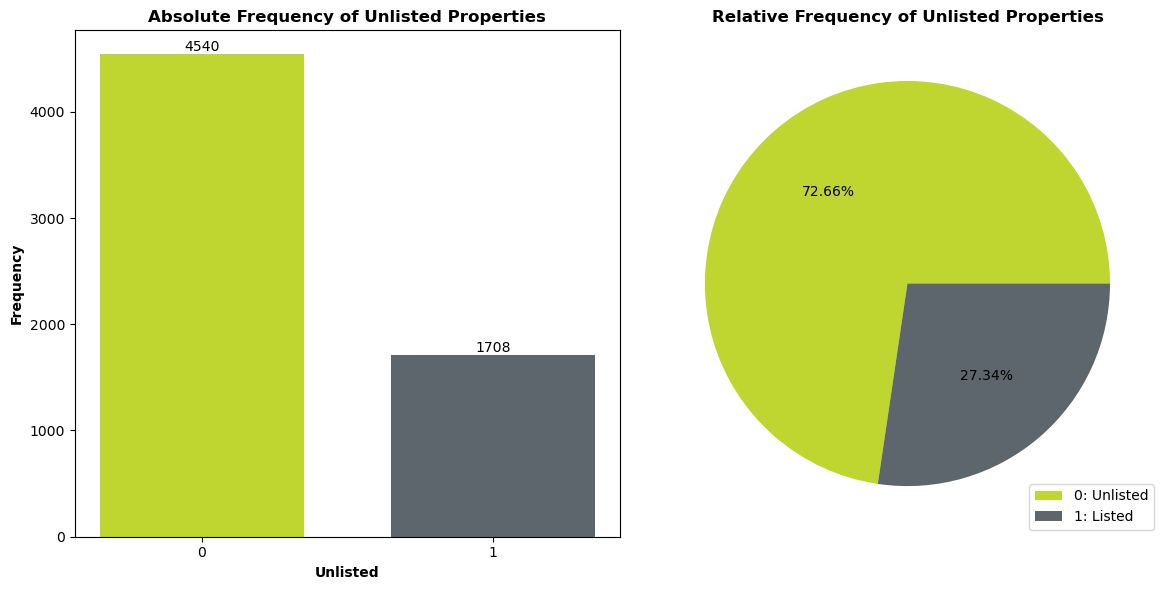

In [257]:
import matplotlib.pyplot as plt

# Data
unlisted_counts = airbnb_df_train['unlisted'].value_counts()
total_properties = unlisted_counts.sum()
percentages = (unlisted_counts / total_properties) * 100

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot for frequency
bar_colors = ['#BED62F', '#5C666C']
bar_labels = ['0', '1']
bars = axs[0].bar(unlisted_counts.index.astype(str), unlisted_counts, color=bar_colors, width=0.7)
axs[0].grid(False)
axs[0].set_title('Absolute Frequency of Unlisted Properties', fontweight='bold')
axs[0].set_xlabel('Unlisted', fontweight='bold')
axs[0].set_ylabel('Frequency', fontweight='bold')
axs[0].tick_params(axis='x', rotation=0)
axs[0].set_xticks(unlisted_counts.index)
axs[0].set_xticklabels(bar_labels)
for p in bars:
    axs[0].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

# Add legend
legend_labels = ['0: Unlisted', '1: Listed']

# Pie chart for percentages
pie_colors = ['#BED62F', '#5C666C']
wedges, texts, autotexts = axs[1].pie(percentages, autopct='%1.2f%%', colors=pie_colors)
axs[1].set_title('Relative Frequency of Unlisted Properties', fontweight='bold')

# Add legend
axs[1].legend(wedges, legend_labels, loc='lower right')

plt.tight_layout()
plt.show()


In [258]:
airbnb_df_train['unlisted'].value_counts(normalize=True)*100

unlisted
0    72.663252
1    27.336748
Name: proportion, dtype: float64

**Conclusions - Target Analysis:**
* No **mising values**  (i.e count = total number of lines)
* No **unexpected values** 
* There is a clear **unbalance**: around 73% of the training instances represent airbnb's that remain listed, while only 27% represent airbnb's that were unlisted.
    - This is an important characteristic of the data, as unbalanced data needs to be adressed so it does not affect the performance of our classification models.

##### **2.2.2 description:**

##### **1) Overall Analysis**

In [259]:
airbnb_df_train['description'].describe()

count                                  6248
unique                                 6023
top       <b>License number</b><br />Exempt
freq                                     19
Name: description, dtype: object

In [260]:
airbnb_df_train['description'].isna().sum()

0

In [261]:
airbnb_df_train['description'].duplicated().sum()

225

**Conclusions**:
* The **most common description** is repeated 19 times, and there are 6023 unique property descriptions, so that there are **duplicated descriptions**.
* There are **no missing values**.



##### **2) Word Count** 
Turn text into words to better analyse it:
Turning our descriptions into tokens and counting how many tokens exist in each description:

In [262]:
airbnb_df_train['word_count_descr']  = airbnb_df_train['description'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train[['description','word_count_descr']].head() #number of tokens

,description,word_count_descr
index,,
1,"This is a shared mixed room in our hostel, wit...",127
2,"O meu espaço fica perto de Parque Eduardo VII,...",23
3,Trafaria’s House is a cozy and familiar villa ...,170
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",47
5,Joli appartement en bordure de mer.<br /> 2 m...,101


In [263]:
airbnb_df_train.word_count_descr.describe().round(2)

count    6248.00
mean      132.86
std        48.08
min         3.00
25%        99.00
50%       157.00
75%       167.00
max       210.00
Name: word_count_descr, dtype: float64

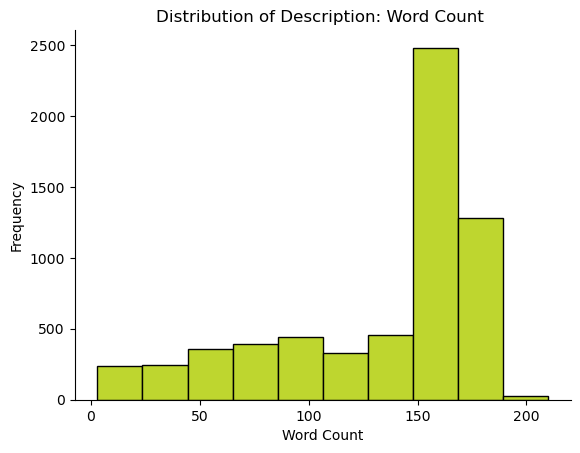

In [264]:
airbnb_df_train['word_count_descr'].hist(ec = 'black', color=['#BED62F'])
plt.grid(False)  
plt.title('Distribution of Description: Word Count ')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Conclusions**:
From these descriptive statistics and histogram, we can understand some interesting things about our data, such as:
- The largest description has 210 words
- The smallest description has only 3 words
- On average, descriptions have around 133 words
- The descripiton filed contains text with many different sizes, by is most commonly around [150,170] words.

##### **3) Word Analysis** 
We now analyse each word individually:

In [265]:
all_words_descr = ' '.join(airbnb_df_train['description']).split()

In [266]:
freq_descr = pd.Series(all_words_descr).value_counts() #see frequency of words

Cheking the **most common words**:

In [267]:
freq_descr.sort_values(ascending=False)[0:25]

the             31323
and             27698
a               25540
/><br           17380
to              15328
of              15122
in              13866
with            13649
is              12083
de               6918
apartment        6841
for              6153
you              6140
<br              5328
has              4863
space</b><br     4814
/><b>The         4670
from             4363
e                4288
/>The            4144
The              3426
are              3155
room             3016
located          2944
2                2937
Name: count, dtype: int64

Vizualising using a barplot:

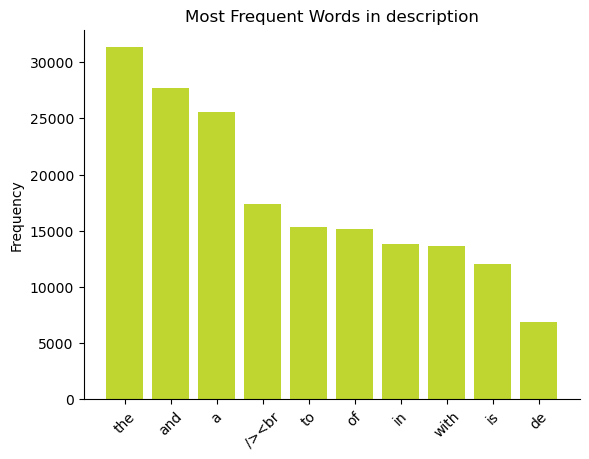

In [268]:
x_labels = freq_descr.index[0:10]
values = freq_descr[:10]
plt.bar(x_labels, values, color=['#BED62F'] )
plt.xticks(x_labels)
plt.ylabel('Frequency')
plt.title('Most Frequent Words in description')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation = 45)
plt.show()

Visualizing using a word cloud:

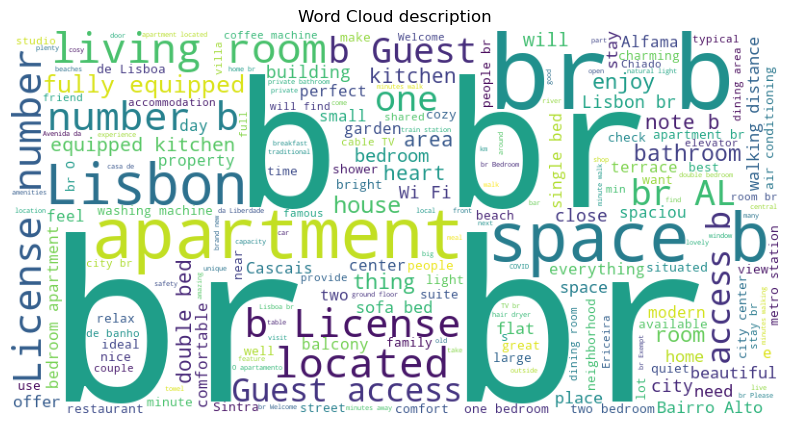

In [269]:
# Joining all the descriptions into a single string
all_reviews_descr = ' '.join(airbnb_df_train['description'])
    
# Create WordCloud object
wordcloud_descr = WordCloud(width=800, height=400, background_color="white").generate(all_reviews_descr)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_descr)
plt.axis("off")
plt.title('Word Cloud description')
plt.show()

**Conclusions**:

There are clearly a lot of **uniformative words** that can be considered *stop words*, *tags* or *non-alphanumeric*, such as 'br', 'and' 'the'.\
These word should be correctly pre-processed as to not affect the outcome of our final analysis.

##### **2.2.3 host_about:**

##### **1) Overall Analysis**

In [270]:
airbnb_df_train['host_about'].describe()

count                                                  6248
unique                                                 2803
top       We are Feels Like Home Holiday Rentals.\nA com...
freq                                                    153
Name: host_about, dtype: object

In [271]:
airbnb_df_train['host_about'].isna().sum()

0

In [272]:
airbnb_df_train['host_about'].duplicated().sum()

3445

**Conclusions**:
* There are only 2.803 **unique host_about descriptions**. This might be due to the fact that the same host might have many properties. Additionally, the **most common host_about** information is repeated 153 times.
* There are **no missing values**.

##### **2) Word Count** 
Repeat the process but this time for the variable *host_about*

In [273]:
airbnb_df_train['word_count_host']  = airbnb_df_train['host_about'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train[['host_about','word_count_host']].head() #number of tokens

,host_about,word_count_host
index,,
1,Alojamento Local Registro: 20835/AL,4
2,"I am friendly host, and I will try to always b...",24
3,"I am a social person liking to communicate, re...",45
4,Hello!_x000D_\nI m Portuguese and i love to me...,31
5,Nous sommes une famille avec deux enfants de 1...,37


In [274]:
airbnb_df_train.word_count_host.describe().round(2)

count    6248.00
mean       73.65
std        79.66
min         1.00
25%        26.00
50%        55.00
75%       101.00
max      1387.00
Name: word_count_host, dtype: float64

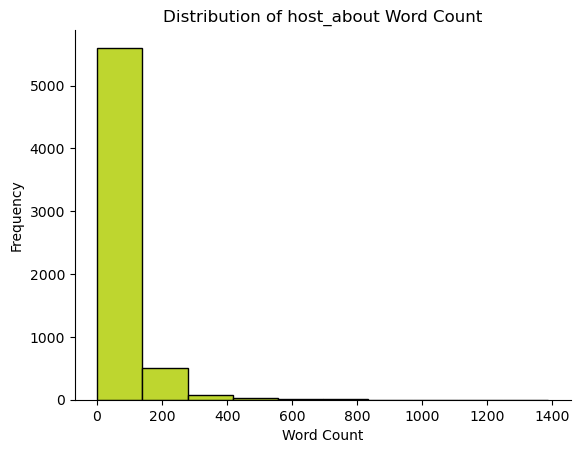

In [275]:
airbnb_df_train['word_count_host'].hist(ec = 'black', color=['#BED62F'])
plt.grid(False)  
plt.title('Distribution of host_about Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Conclusions**:
From these descriptive statistics and histogram, we can understand some interesting things about our data, such as:
- The largest description of the host has 1387 words
- The smallest description of the host has only 1 word
- On average, descriptions of the hosts  have around 74 words
- The *host_about* filed has generally smaller text [0,100] words, but also has extreme outliers with 10 times more words.

##### **3) Word Analysis** 
We now analyse each word individually:

In [276]:
all_words_host= ' '.join(airbnb_df_train['host_about']).split()

In [277]:
freq_host = pd.Series(all_words_host).value_counts() #see frequency of words

Cheking the most common words:

In [278]:
freq_host.sort_values(ascending=False)[0:20]

and        16358
to         13291
the        10797
a          10535
in          9860
of          6524
I           6419
you         6248
de          4325
We          4206
our         4004
e           3980
_x000D_     3971
for         3864
with        3819
is          3506
we          3481
are         2929
have        2825
my          2750
Name: count, dtype: int64

Vizualising using a barplot:

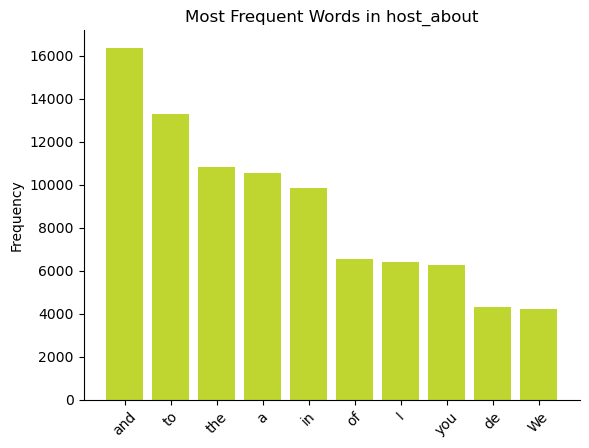

In [279]:
x_labels = freq_host.index[0:10]
values = freq_host[:10]
plt.bar(x_labels, values, color=['#BED62F'] )
plt.xticks(x_labels)
plt.ylabel('Frequency')
plt.title('Most Frequent Words in host_about')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation = 45)
plt.show()

Visualizing using a word cloud:

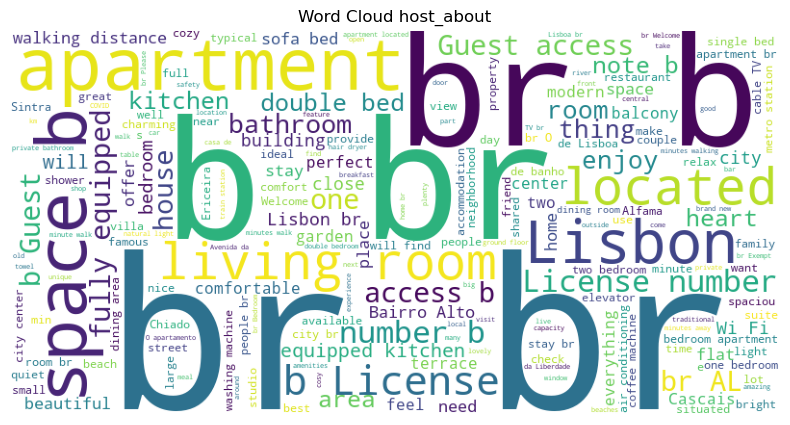

In [280]:
# Joining all the host_about into a single string
all_reviews_host = ' '.join(airbnb_df_train['host_about'])
    
# Create WordCloud object
wordcloud_descr = WordCloud(width=800, height=400, background_color="white").generate(all_reviews_descr)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_descr)
plt.axis("off")
plt.title('Word Cloud host_about')
plt.show()

**Conclusions:**

There are clearly a lot of uniformative words that can be considered stop words, tags or non-alphanumeric, such as 'br', 'and' 'to'.\
These word should be correctly pre-processed as to not affect the outcome of our final analysis.

##### **2.2.4 comments:**

##### **1) Overall Analysis**

In [281]:
airbnb_df_train_reviews['comments'].isna().sum()

2

In [282]:
rows_with_nan_comments = airbnb_df_train_reviews[airbnb_df_train_reviews['comments'].isna()]
rows_with_nan_comments

,index,comments
97996,1654,NaN
334443,5789,NaN


In [283]:
airbnb_df_train_reviews['comments'].duplicated().sum()

6781

**Conclusions:**

We have **2 missing values** and have **many duplicated values**.

##### **2) Word Count** 
Repeat the process but this time for the variable *comments*

In [284]:
airbnb_df_train_reviews['word_count_rev']  = airbnb_df_train_reviews['comments'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train_reviews[['comments','word_count_rev']].head() #number of tokens

,comments,word_count_rev
0,this is a very cozy and comfortable house to s...,28
1,good<br/>,1
2,"My first hostel experience, and all I have to ...",261
3,Das Hostel war neu und deshalb funktionierte a...,81
4,"It was fine for a dorm, but I think for the pe...",27


In [285]:
airbnb_df_train_reviews.word_count_rev.describe().round(2)

count    361281.00
mean         47.97
std          46.79
min           1.00
25%          18.00
50%          36.00
75%          63.00
max        1019.00
Name: word_count_rev, dtype: float64

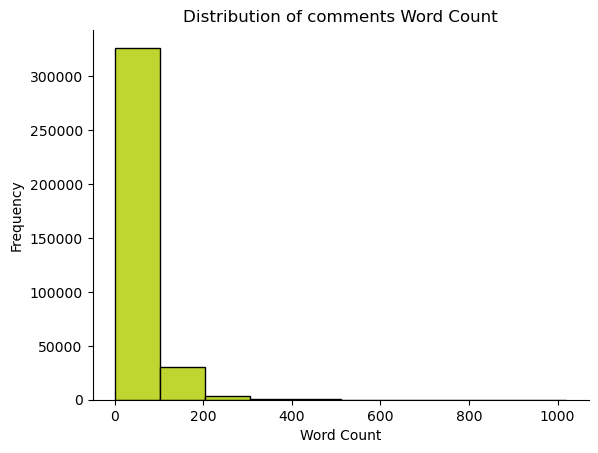

In [286]:
airbnb_df_train_reviews['word_count_rev'].hist(ec = 'black', color=['#BED62F'])
plt.grid(False)  
plt.title('Distribution of comments Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Conclusions**:
From these descriptive statistics and histogram, we can understand some interesting things about our data, such as:
- The largest comment has 1019 words
- The smallest comment has only 1 word
- On average, comments of the hosts  have around 48 words
- Just as with *host_about*, most *comments* have around [1,63] words but some outliers are 10 times bigger.

##### **3) Word Analysis** 
We now analyse each word individually:

In [287]:
#all_words_rev= ' '.join(airbnb_df_train_reviews['comments']).split()

The code line from above would not work as we are dealing with a variable with missing values encoded as *NaN*. This being said, we explore the problem further:

In [288]:
problematic_indices = []

for index, comment in airbnb_df_train_reviews['comments'].items():
    if isinstance(comment, float):
        problematic_indices.append(index)

problematic_rows = airbnb_df_train_reviews.loc[problematic_indices]
print(problematic_rows)

        index comments  word_count_rev
97996    1654      NaN               1
334443   5789      NaN               1


In [289]:
#The problem occurs because we have missing values, so let's no consider them (drop them)
comments_without_missing = airbnb_df_train_reviews['comments'].dropna()
all_words_rev = ' '.join(comments_without_missing).split()

In [290]:
freq_rev = pd.Series(all_words_rev).value_counts() #see frequency of words

Cheking the most common words:

In [291]:
freq_rev.sort_values(ascending=False)[0:15]

and          553157
the          515963
a            398631
to           328675
is           258191
in           249469
was          239807
of           174087
very         156654
The          143987
for          141658
de           139290
with         115782
apartment    114848
we            98283
Name: count, dtype: int64

Vizualising using a barplot:

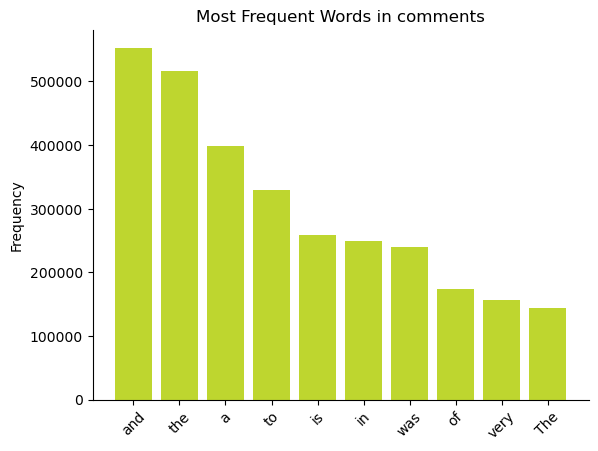

In [292]:
x_labels = freq_rev.index[0:10]
values = freq_rev[:10]
plt.bar(x_labels, values, color=['#BED62F'] )
plt.xticks(x_labels)
plt.ylabel('Frequency')
plt.title('Most Frequent Words in comments')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation = 45)
plt.show()

Visualizing using a word cloud:

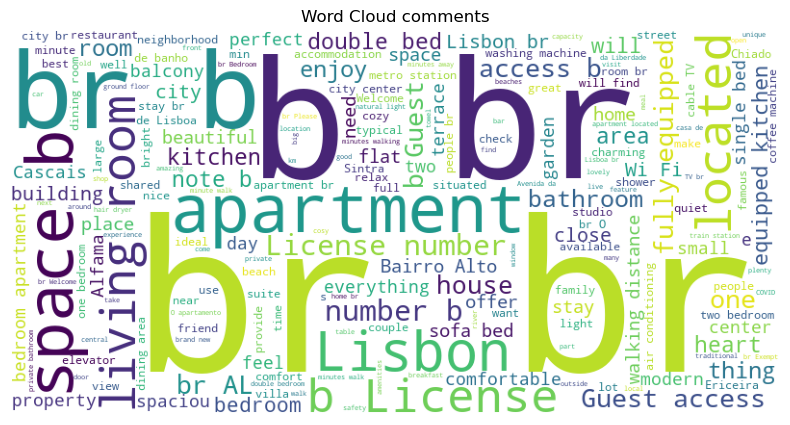

In [293]:
# Joining all the comments into a single string
all_reviews_rev = ' '.join(comments_without_missing)
    
# Create WordCloud object
wordcloud_descr = WordCloud(width=800, height=400, background_color="white").generate(all_reviews_descr)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_descr)
plt.axis("off")
plt.title('Word Cloud comments')
plt.show()

**Note:**

Although we have conducted an analysis suggesting that comments may be important for unlisting, we acknowledge that sometimes comments can consist of empty strings, spaces, dots, or punctuation marks that don't provide useful information for our problem context. 
Therefore, let´s check comments with 5 characters and determine the number of such comments in the dataset.

In [294]:
columns = ['comments']

# Iterate over the specified columns
for column in columns:
    # Filter the dataset to retrieve the short comments
    short_comments = train_reviews[train_reviews[column].str.len() < 5][column].unique()
    # Print the header for the short comments
    print(f"Short comments in {column}:")
    # Iterate over the short comments and print them
    for comment in short_comments:
        print(comment)

Short comments in comments:
top
.
I
👍
Good
q
-
Top
bien
Bien
Bom.
非常满意
RAS
Bom
O
♥️
show
💚
ø
....
Na
🤙🏼
👍🏼
A
Si
...
nice
J
G
..
idem
Idem
😊
K
Ras
👌
å
Ok
Nice
Nee
****
Xxx
/
5/5
👍🏼👍🏼
:-)
L
r
🙂
!
Hi
Top!
…
🔝
Bb
👍🏻
Best
좋습니다
Nul
❤️
10
🇵🇹
x
nvt
´
!!!
NC
Ok.
E
 ...
no
😍😍😍
좋았음
🙏🏻
xxx
good
👌👌👌
ok
:)
很接地气
,
OK
N.
No
X
👍👍👍
We
D
n
非常完美
Hduj
aa
non
5*
אש
Kind
N/a
C
Gut
👍👍
좋아요
👌🏻👌🏻
S
6*!!
1
Omit
Cool
Amei
N
nada
😎😎😎😎
  . 
A+++
😉
Gh
+
Goed
Z
👌🏼👌🏼
非常好
Xx
1A
M
•
🔝🔝🔝
. 
GG
A*
👌🏾
Hh
Fab!
都很好！
挺好的
非常好👍
非常干净
_
v
cfgx
B
A a
P
五星推荐
‘
T
✌️🪨
Tks
🙏
رائع
2/5
***
Gos
5🌟
Top 
Ds
…..
✔️
👍👍👍👍
  👌🏻
😘
Ok😊
a
5⭐️
;-))
Nada
👌🏻
?
좋아요!
1 A
gut
Df
Nn
TB
🙌🏻
Veld
SN
+++👍
top!
✨
🙌🏾
0
Boa
Test
Ya
无
<3
😀
很舒适
100%
👍👌
💗
5 ⭐️
🤗
g
Grat
tnx
👌🏽
Aaaa
很好
Oui
👍🏽
☹️👎🏽
5*!
ooo
🤨
  C
Q
👌👌
还可以
Fine
Mega
Okay
**
体验不错
Thx
👍🏼👏🏼
we
i
5✨
9
Nvt
ciao
👍🏾
N/à
非常喜欢
位置不错
hu
👌🏼
👌👍
Apa
U
Todo
R
p
很干净
boa
d
--
BIEN
8.0
👍🏻🤟🏻
The 
Mhe
none
SO
cool
👏🏻
bom
好
很棒！
超赞！
9/10
Bom!
c
n/A
xx
..!
Yes!
ppp
Arnm
*
H
Yo
Guay
😉👌
The
☹️
🤟👍
🎷🦫
–
—-
Www
RAS.
: )
Boa.
yes


**Conclusions:**
There are clearly a lot of uniformative words that can be considered stop words, tags, emojis or non-alphanumeric, such as 'br', 'and' 'the'.\ These words should be correctly pre-processed as to not affect the outcome of our final analysis.

#### **2.3 Multi-Language Analysis**

As was noted earlier, our text is written in many different languages. An important step of our analysis is to understand the proportions in which each language is present in our text, as to select the best approach going forward.

In [295]:
# Defining a function to define the language of each comment using the langdetect library
def detect_language(text):
    try:
        return detect(text)
    except:
        # Returns unknown if it doesn't recognize the language
        return "Unknown"

In [296]:
#Apply the function to "description" & "host_about" in airbnb_df_train
airbnb_df_train['desc_lang'] = airbnb_df_train['description'].apply(detect_language)
airbnb_df_train['ha_lang']=airbnb_df_train['host_about'].apply(detect_language)

In [297]:
airbnb_df_train[['desc_lang', 'ha_lang' ]].describe().T

,count,unique,top,freq
desc_lang,6248,12,en,5108
ha_lang,6248,30,en,4442


In [298]:
#Apply the function to "comments" in airbnb_df_train_reviews
airbnb_df_train_reviews['com_lang'] = airbnb_df_train_reviews['comments'].apply(detect_language)

In [299]:
airbnb_df_train.to_csv('airbnb_df_train_lang.csv', index=False)
airbnb_df_train_reviews.to_csv('airbnb_df_train_reviews_lang.csv', index=False)

In [300]:
airbnb_df_train_reviews['com_lang'].describe()

count     361281
unique        44
top           en
freq      232368
Name: com_lang, dtype: object

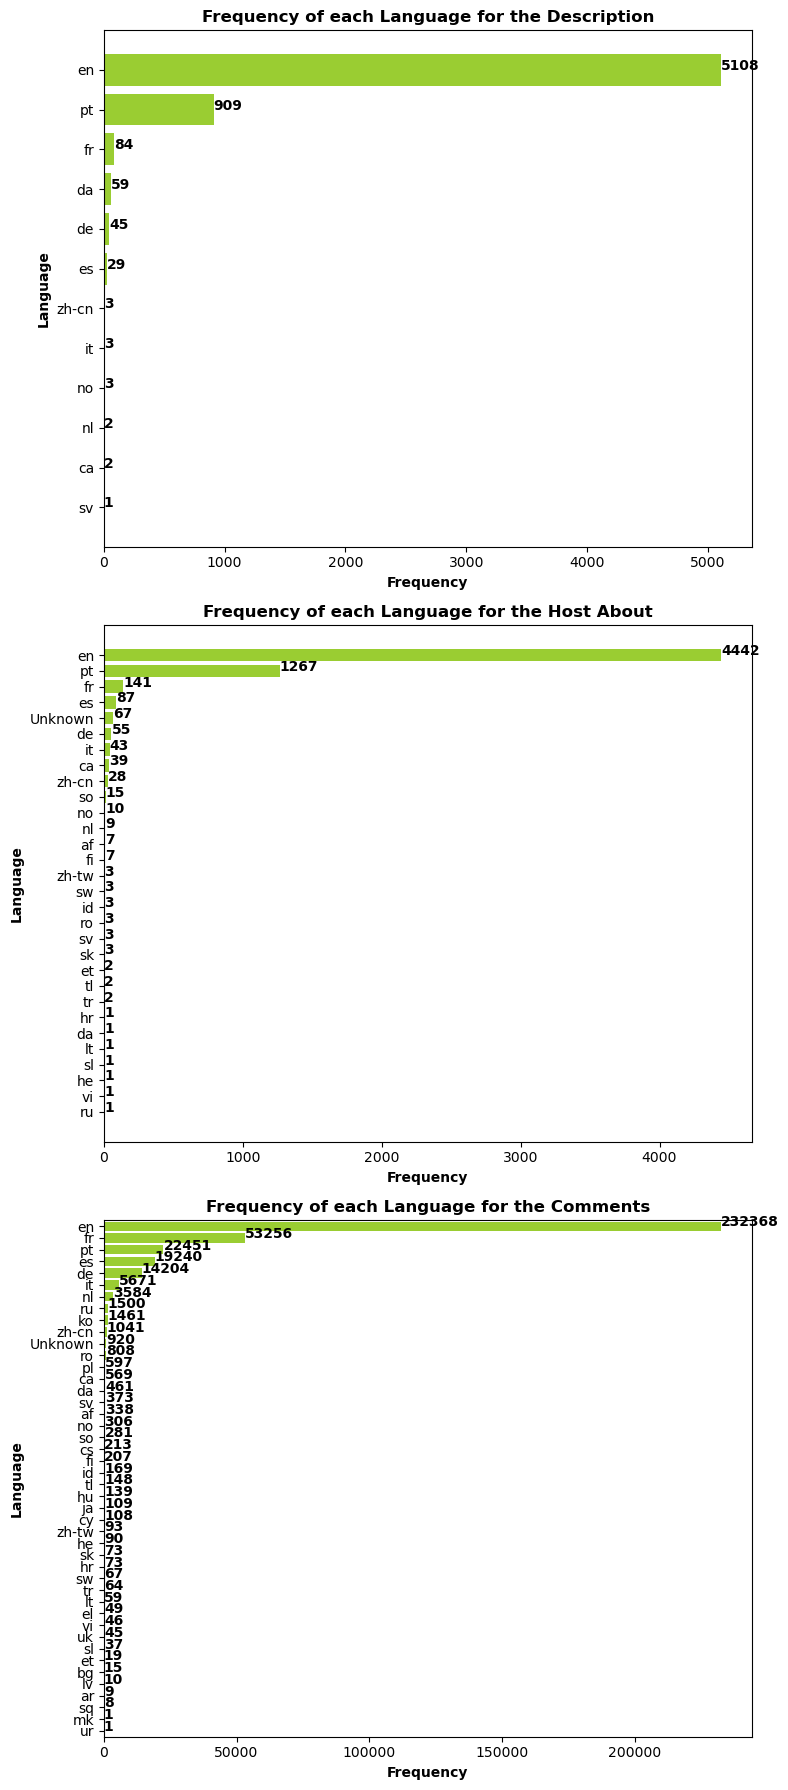

In [301]:
# Data
desc_lang_counts = airbnb_df_train['desc_lang'].value_counts()
ha_lang_counts = airbnb_df_train['ha_lang'].value_counts()
com_lang_counts = airbnb_df_train_reviews['com_lang'].value_counts()

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 18))

# Horizontal bar plot for description language
desc_lang_counts_sorted = desc_lang_counts.sort_values(ascending=True)
axs[0].barh(desc_lang_counts_sorted.index, desc_lang_counts_sorted, color='yellowgreen')
axs[0].grid(False)
axs[0].set_title('Frequency of each Language for the Description', fontweight='bold')
axs[0].set_xlabel('Frequency', fontweight='bold')
axs[0].set_ylabel('Language', fontweight='bold')

for i, v in enumerate(desc_lang_counts_sorted):
    axs[0].text(v + 0.2, i, str(v), color='black', fontweight='bold')

# Horizontal bar plot for host about language
ha_lang_counts_sorted = ha_lang_counts.sort_values(ascending=True)
axs[1].barh(ha_lang_counts_sorted.index, ha_lang_counts_sorted, color='yellowgreen')
axs[1].grid(False)
axs[1].set_title('Frequency of each Language for the Host About', fontweight='bold')
axs[1].set_xlabel('Frequency', fontweight='bold')
axs[1].set_ylabel('Language', fontweight='bold')

for i, v in enumerate(ha_lang_counts_sorted):
    axs[1].text(v + 0.2, i, str(v), color='black', fontweight='bold')

# Horizontal bar plot for comment language
com_lang_counts_sorted = com_lang_counts.sort_values(ascending=True)
axs[2].barh(com_lang_counts_sorted.index, com_lang_counts_sorted, color='yellowgreen')
axs[2].grid(False)
axs[2].set_title('Frequency of each Language for the Comments', fontweight='bold')
axs[2].set_xlabel('Frequency', fontweight='bold')
axs[2].set_ylabel('Language', fontweight='bold')

for i, v in enumerate(com_lang_counts_sorted):
    axs[2].text(v + 0.2, i, str(v), color='black', fontweight='bold')

# Adjusting vertical scale for comments language plot
axs[2].set_ylim(-0.5, len(com_lang_counts_sorted) - 0.5)

plt.tight_layout()
plt.show()


Regarding the distribution of relative frequency, we'll create pie charts. However, for better interpretation, each chart will only represent languages with a representation above 5%. All others will be included in the "Others" category.

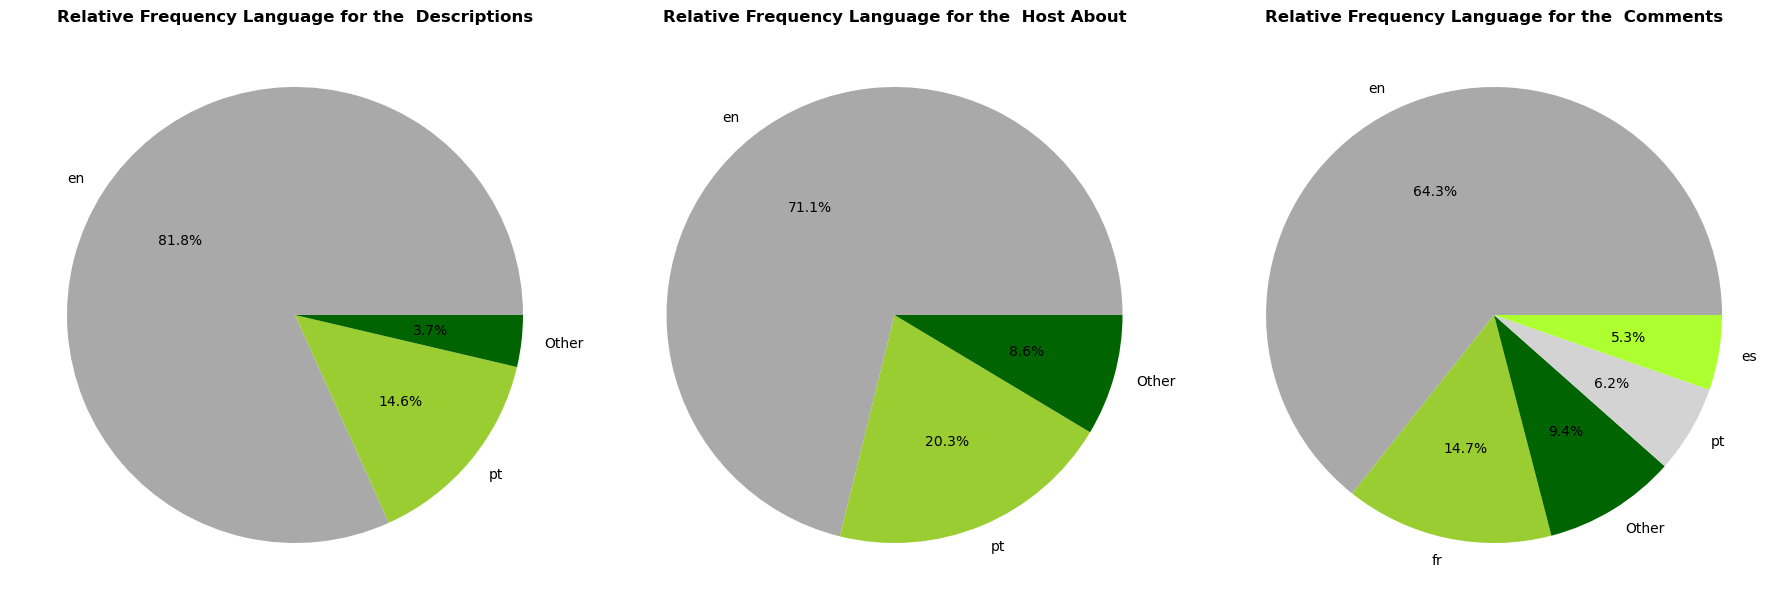

In [214]:
# let's aggregate all the languages in less than 5% of the data for each column in one category called other

#Function to aggregate the small categories
def aggregate_categories(counts):
    total_count = counts.sum()
    filtered_counts = counts[counts / total_count * 100 > 5]
    other_count = total_count - filtered_counts.sum()
    return filtered_counts, other_count

# Counts
desc_lang_counts = airbnb_df_train['desc_lang'].value_counts()
ha_lang_counts = airbnb_df_train['ha_lang'].value_counts()
com_lang_counts = airbnb_df_train_reviews['com_lang'].value_counts()

# Aggregate small categories
desc_lang_counts_filtered, desc_lang_others = aggregate_categories(desc_lang_counts)
ha_lang_counts_filtered, ha_lang_others = aggregate_categories(ha_lang_counts)
com_lang_counts_filtered, com_lang_others = aggregate_categories(com_lang_counts)

# Create temporary columns
airbnb_df_train['desc_lang_temp'] = airbnb_df_train['desc_lang'].apply(lambda x: x if x in desc_lang_counts_filtered else 'Other')
airbnb_df_train['ha_lang_temp'] = airbnb_df_train['ha_lang'].apply(lambda x: x if x in ha_lang_counts_filtered else 'Other')
airbnb_df_train_reviews['com_lang_temp'] = airbnb_df_train_reviews['com_lang'].apply(lambda x: x if x in com_lang_counts_filtered else 'Other')



# Use the temporary columns to plot the pie charts
desc_lang_counts_temp = airbnb_df_train['desc_lang_temp'].value_counts()
ha_lang_counts_temp = airbnb_df_train['ha_lang_temp'].value_counts()
com_lang_counts_temp = airbnb_df_train_reviews['com_lang_temp'].value_counts()

# Define colors
colors = ['darkgrey','yellowgreen', 'darkgreen', 'lightgrey', 'greenyellow']

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Pie chart for description language
axs[0].pie(desc_lang_counts_temp, labels=desc_lang_counts_temp.index, autopct='%1.1f%%', colors=colors)
axs[0].set_title('Relative Frequency Language for the  Descriptions', fontweight='bold')

# Pie chart for host about language
axs[1].pie(ha_lang_counts_temp, labels=ha_lang_counts_temp.index, autopct='%1.1f%%', colors=colors)
axs[1].set_title('Relative Frequency Language for the  Host About', fontweight='bold')

# Pie chart for comment language
axs[2].pie(com_lang_counts_temp, labels=com_lang_counts_temp.index, autopct='%1.1f%%', colors=colors)
axs[2].set_title('Relative Frequency Language for the  Comments', fontweight='bold')

plt.tight_layout()
plt.show()


**Conclusion**

|                        |    Description  |     Host About    |        Comments |
|---                     |         ---     |           ---     |   ---           |
| # Distintic languages  |        12       |       30          |  44
| +/-95 %   |    en-pt        |      en-pt       |  en-fr-pt-es |


#### **2.4  Conclusions Data Exploration:**
- Target variable *unlisted* is unbalaned (73/27);
- Text fields appear in many languages ( the majority in english and portuguese);
- Duplicated entries will be considered different properties;
- Missing values were found for the field *comments*;
- All text fileds have many stop words, tags and non-alphanumeric words that should be removed for a better analysis.


------

### **3. Data Preprocessing**

<div class="alert alert-block alert-success"> <a id = "preprocessing"></a>

# **REQUIREMENTS** 

- Split Training corpus intro train/validation sets (or also K-Fold Cross Validation or others);
- Implement at least 4 preprocessing techniques (stop words, regular expressions, lemmatization, stemming, …)
- Apply more data exploration after preprocessing.

Extra work: 0.25 points for each extra method (unseen in class) - max 2 methods
1. Normalization:
- Replace links with special token
- Normalize dates
- Regular expressions

2. LowerCasing

3. Tokenization
- Coumpounds
- Punctuation
4. Remove Stop-Words

5. Stemming and lemmatisation
6. POS filtering


####  **3.1 Combined Dataset:**

**Assumption**: Given our initail analysis we decided to use *comments* for predicting unlisting and also *description*, since not all houses have comments. So that we will merge those feautures in a combine dataset.

In [312]:
# Reading the train datasets with language  detect
airbnb_df_train_lang = pd.read_csv('airbnb_df_train_lang.csv')
airbnb_df_train_reviews_lang = pd.read_csv('airbnb_df_train_reviews_lang.csv')

In [309]:
airbnb_df_train_lang.head()

,description,host_about,unlisted,word_count_descr,word_count_host,desc_lang,ha_lang
0,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,127,4,en,pt
1,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,23,24,pt,en
2,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,170,45,en,en
3,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,47,31,pt,en
4,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,101,37,fr,fr


In [310]:
columns_to_drop=['word_count_descr',	'word_count_host']
airbnb_df_train_lang.drop(columns=columns_to_drop, axis=1, inplace=True)
airbnb_df_train_lang.head()

,description,host_about,unlisted,desc_lang,ha_lang
0,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt
1,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en
2,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en
3,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,pt,en
4,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr


In [340]:
airbnb_df_train_lang['house_id']=airbnb_df_train_lang.index+1

In [341]:
airbnb_df_train_lang.head()

,description,host_about,unlisted,word_count_descr,word_count_host,desc_lang,ha_lang,house_id
0,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,127,4,en,pt,1
1,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,23,24,pt,en,2
2,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,170,45,en,en,3
3,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,47,31,pt,en,4
4,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,101,37,fr,fr,5


In [342]:
airbnb_df_train_reviews_lang.head()

,index,comments,com_lang
0,1,this is a very cozy and comfortable house to s...,en
1,1,good<br/>,cy
2,1,"My first hostel experience, and all I have to ...",en
3,1,Das Hostel war neu und deshalb funktionierte a...,de
4,1,"It was fine for a dorm, but I think for the pe...",en


In [344]:
airbnb_df_train_reviews_lang.drop(columns='word_count_rev', axis=1, inplace=True)
airbnb_df_train_reviews_lang.head()

,index,comments,com_lang
0,1,this is a very cozy and comfortable house to s...,en
1,1,good<br/>,cy
2,1,"My first hostel experience, and all I have to ...",en
3,1,Das Hostel war neu und deshalb funktionierte a...,de
4,1,"It was fine for a dorm, but I think for the pe...",en


In [345]:
# Step 1: Group airbnb_df_train_reviews_lang by 'index' and aggregate comments and languages separately
aggregated_comments = airbnb_df_train_reviews_lang.groupby('index')['comments'].agg(list)
aggregated_languages = airbnb_df_train_reviews_lang.groupby('index')['com_lang'].agg(set)

# Step 2: Merge the aggregated comments and languages dataframes based on 'index'
merged_df = pd.merge(aggregated_comments, aggregated_languages, on='index', how='outer')

# Step 3: Merge merged_df with airbnb_df_train_lang based on the index of the dataframe
merged_df = pd.merge(airbnb_df_train_lang, merged_df, left_on='house_id', right_on='index', how='left')

# Step 4: Create a new dataframe with desired columns
combined_df = merged_df[['house_id','description', 'desc_lang', 'comments', 'com_lang', 'unlisted']]

# Display the new dataframe
combined_df


,house_id,description,desc_lang,comments,com_lang,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",en,[this is a very cozy and comfortable house to ...,"{de, cy, pt, es, fr, en, ru}",0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...",pt,NaN,NaN,1
2,3,Trafaria’s House is a cozy and familiar villa ...,en,NaN,NaN,1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",pt,NaN,NaN,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,fr,[Un très bel appartement avec une magnifique v...,"{de, pt, es, nl, en, fr}",0
...,...,...,...,...,...,...
6243,6244,"Studio 15 is a new, very well decorated and co...",en,"[Ottimo host, gentile, veloce e simpatico.<br/...","{de, it, he, pt, es, nl, en, fr}",0
6244,6245,Lisbon meets a cosmopolitan industrial one-bed...,en,[Newly & nicely refurbished apartment (May 201...,"{de, it, pt, es, nl, fr, en, ko, ru}",0
6245,6246,<b>License number</b><br />Exempt,en,[Do not recommend. <br/><br/>Host extremely ha...,"{de, it, pt, es, fr, en}",1
6246,6247,Campo Pequeno Prestige is a classy and top qua...,en,"[Maria is an amazing host, the entire place is...","{de, pt, es, en}",0


In [360]:
# Checking the unique values of the language of the comments
flattened_list = [item for sublist in combined_df['com_lang'].dropna() for item in sublist]
# Get unique values using set() function
unique_values = list(set(flattened_list))

unique_values


['cy',
 'hu',
 'el',
 'mk',
 'af',
 'zh-tw',
 'sl',
 'lv',
 'id',
 'de',
 'he',
 'hr',
 'pt',
 'es',
 'vi',
 'bg',
 'ja',
 'en',
 'ar',
 'et',
 'pl',
 'Unknown',
 'da',
 'sw',
 'lt',
 'it',
 'so',
 'sk',
 'ur',
 'nl',
 'ko',
 'zh-cn',
 'cs',
 'sv',
 'uk',
 'fi',
 'tr',
 'ca',
 'sq',
 'fr',
 'tl',
 'no',
 'ro',
 'ru']

In [362]:
# Checkin the information of the combined_df dataset
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6248 entries, 0 to 6247
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   house_id     6248 non-null   int64 
 1   description  6248 non-null   object
 2   desc_lang    6248 non-null   object
 3   comments     4245 non-null   object
 4   com_lang     4245 non-null   object
 5   unlisted     6248 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 293.0+ KB


In [363]:
combined_df.comments.isna().sum()

2003

**Conclusion:**
According to the previous exploration we conducted, we found that we have 4245 comments out of a total of 6248. This is confirmed by the presence of 2003 missing values in the *comments* column, and consequently in the *com_lang* feature.

####  **3.2  Treating Missing Values:**

Let's start by dealing with the missing values found:

In [215]:
airbnb_df_train_reviews['comments'] = airbnb_df_train_reviews['comments'].fillna('')

In [218]:
airbnb_df_train_reviews.info() # to check if they are filled with ' '

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361281 entries, 0 to 361280
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           361281 non-null  int64 
 1   comments        361281 non-null  object
 2   word_count_rev  361281 non-null  int64 
 3   com_lang        361281 non-null  object
 4   com_lang_temp   361281 non-null  object
dtypes: int64(2), object(3)
memory usage: 13.8+ MB


####  **3.2 HTML tags:**

One of the problems detected was the presence of HTML tags in the documents, so we will remove it, the **Beautiful Soup**.

* **Beautiful Soup**: Python library used for parsing HTML and XML documents, providing convenient methods for navigating, searching, and modifying the parse tree.
* documentation: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

In [230]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    clean_text = soup.get_text(separator=' ')
    return clean_text

In [231]:
airbnb_df_train['description'] = airbnb_df_train['description'].apply(remove_html_tags)
airbnb_df_train['host_about'] = airbnb_df_train['host_about'].apply(remove_html_tags)
airbnb_df_train_reviews['comments'] = airbnb_df_train_reviews['comments'].apply(remove_html_tags)

C:\Users\maria\AppData\Local\Temp\ipykernel_16416\335289268.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
C:\Users\maria\AppData\Local\Temp\ipykernel_16416\335289268.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
C:\Users\maria\AppData\Local\Temp\ipykernel_16416\335289268.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


####  **3.3 Usual Cleaning:**
- Stop words
- Lemmatization
- Steaming 

In [236]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [237]:

def clean(text_list, lemmatize, stemmer):
    
    updates = []
    
    for text in tqdm(text_list):
        
        # Lowercase text
        text = text.lower()
        
        # Remove unnecessary tags and all non-alphabetic characters
        text = re.sub("<br />", "", text)
        text = re.sub("[^a-zA-Z]"," ", text)
        # [^&] - Returns a match for any character EXCEPT &.
        # a-zA-Z - Returns a match for any character alphabetically between a and z, lower case or upper case.
        
        # Remove stopwords
        text = " ".join([word for word in text.split() if word not in stop])
        
        # Lemmatize
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        # Stemming
        if stemmer:
            text = " ".join(stemmer.stem(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [241]:
updates_description = clean(airbnb_df_train['description'], lemmatize = True, stemmer = False)

100%|██████████| 6248/6248 [00:09<00:00, 654.75it/s] 


In [242]:
updates_host = clean(airbnb_df_train['host_about'], lemmatize = True, stemmer = False)

100%|██████████| 6248/6248 [00:02<00:00, 2528.89it/s]


In [243]:
updates_comments = clean(airbnb_df_train_reviews['comments'], lemmatize = True, stemmer = False)

100%|██████████| 361281/361281 [01:51<00:00, 3246.66it/s]


To check the differcence after and before the cleaning, lets co

In [247]:
airbnb_df_train['description'][50]


'Show up and start living from day one in Lisbon with this cozy two-bedroom Blueground apartment. You’ll love coming home to this thoughtfully furnished, beautifully designed, and fully-equipped Baixa home. (ID #LIS48) The space Gorgeous furniture, fully-equipped kitchen, smart TV, and a premium wireless speaker are just a few of the amenities you’ll find inside this two-bedroom apartment. Ideally located in Lisbon, you’ll find a lot to love outside as well. When you’re ready to relax, you’ll be happy to discover every Blueground bedroom comes with superior quality mattresses, luxury linens, and cozy towels. We handle everything so you can simply show up and start living.  Amenities Building amenities unique to this two-bedroom include an on-site:   - Elevator Please check the house rules prior to booking as other fees and limitations may apply. Other things to note This Blueground apartment has fl'

In [249]:
def update_df(dataframe, column_name, list_updated):
    list_updated.insert(0, None)  # adding an empty object to the first position of the list, so that the ids match with the dataframe
    dataframe.update(pd.DataFrame({column_name: list_updated}))

In [250]:
update_df(airbnb_df_train, 'description', updates_description)
update_df(airbnb_df_train, 'host_about', updates_host)
update_df(airbnb_df_train_reviews, 'comments', updates_comments)

In [251]:
airbnb_df_train['description'][50]

'show start living day one lisbon cozy two bedroom blueground apartment love coming home thoughtfully furnished beautifully designed fully equipped baixa home id li space gorgeous furniture fully equipped kitchen smart tv premium wireless speaker amenity find inside two bedroom apartment ideally located lisbon find lot love outside well ready relax happy discover every blueground bedroom come superior quality mattress luxury linen cozy towel handle everything simply show start living amenity building amenity unique two bedroom include site elevator please check house rule prior booking fee limitation may apply thing note blueground apartment fl'

----

### Feature Engineering:
Implement and experiment with 2 of feature engineering techniques (TF-IDF, GloVe embedding, …).

Extra work: 1 point for each extra method using Transformed-based embedding.- max 2 methods



-----

### Classification Models:
Implement and test 3 of the classification algorithms seen in class (KNN, LR, MLP, LSTM, …).

Extra work: 1 point for each extra model using Transformers or other advanced models - max 2 methods.



- Use KNN as baseline

----

### Evaluation:
Evaluate with, at least, Recall, Precision, Accuracy and F1-Score.
